In [1]:
import os
import splitfolders


In [2]:
input_dir = os.path.join('C:/Users/Mfund/Downloads/flowers/')
output_dir = os.path.join('C:/Users/Mfund/Downloads/flowers/flowers_splitted/')

splitfolders.ratio(input_dir, output_dir,seed=1337, ratio=(.8,.2), group_prefix=None)

Copying files: 4317 files [00:40, 107.62 files/s]


In [4]:
train_dir = os.path.join('C:/Users/Mfund/Downloads/flowers/flowers_splitted/train/')
test_dir = os.path.join('C:/Users/Mfund/Downloads/flowers/flowers_splitted/val/')

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator(train_par_dir, test_par_dir):
    train_datagen = ImageDataGenerator(rescale= 1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator= train_datagen.flow_from_directory(train_par_dir,
                                                     target_size = (75,75),
                                                     batch_size = 214,
                                                     class_mode = 'categorical',
                                                     subset = 'training')
    test_generator = test_datagen.flow_from_directory(test_par_dir,
                                                     target_size = (75,75),
                                                     batch_size = 37,
                                                     class_mode = 'categorical')
    
    return train_generator, test_generator


In [10]:
train_generator,test_generator = image_generator(train_dir,test_dir)

Found 3452 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, MaxPooling2D,Flatten, Dropout

model = Sequential([
    Conv2D(input_shape=(75,75,3), filters=8, kernel_size=16, activation ='relu'),
    MaxPooling2D(2,2),
    Conv2D(32,(3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3), activation= 'relu'),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3), activation ='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(units=5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 8)         6152      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          3

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=100,
    verbose =1)

Epoch 1/100
10/10 [==============================] - 21s 2s/step - loss: 1.5699 - accuracy: 0.2600
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 1.3672 - accuracy: 0.3705
Epoch 3/100
10/10 [==============================] - 10s 956ms/step - loss: 1.3003 - accuracy: 0.4121
Epoch 4/100
10/10 [==============================] - 8s 760ms/step - loss: 1.2629 - accuracy: 0.4365
Epoch 5/100
10/10 [==============================] - 8s 738ms/step - loss: 1.2211 - accuracy: 0.4795
Epoch 6/100
10/10 [==============================] - 8s 755ms/step - loss: 1.2223 - accuracy: 0.4877
Epoch 7/100
10/10 [==============================] - 8s 746ms/step - loss: 1.2106 - accuracy: 0.4811
Epoch 8/100
10/10 [==============================] - 8s 733ms/step - loss: 1.1697 - accuracy: 0.5036
Epoch 9/100
10/10 [==============================] - 8s 736ms/step - loss: 1.1654 - accuracy: 0.5230
Epoch 10/100
10/10 [==============================] - 8s 741ms/step - loss: 1.1220 - accuracy:

In [25]:
import cv2

def import_and_predict(image_data, label):
    
    img = cv2.imread('C:/Users/Mfund/Downloads/flowers/flowers_splitted/val/dandelion/')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize =(75,75), interpolation=cv2.INTER_CUBIC))/255.
    
    img_reshape = img_resize[np.newaxis,...]
    
    prediction = model.predict(img_reshape)
    print(prediction)
    
    label_prediction = label[np.argmax(prediction)]
    
    return label_prediction

label = os.listdir(test_dir)
image1_dir = os.path.join(test_dir+'dandelion/138166590_47c6cb9dd0.jpg')

prediction = import_and_predict(image1_dir,label)


error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [26]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

In [27]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457

model_bayes = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(5), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(5)
    
])
model_bayes.summary()

C:\Users\Mfund\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization (C (None, 60, 60, 8)         12304     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        2336      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)         

In [28]:
from tensorflow.keras.optimizers import Adam

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [29]:
history_bayes = model_bayes.fit(
      train_generator,
      epochs=300,
      verbose=1)

Epoch 1/300
17/17 [==============================] - 16s 815ms/step - loss: 8.0963 - accuracy: 0.2034
Epoch 2/300
17/17 [==============================] - 13s 749ms/step - loss: 7.8197 - accuracy: 0.2010
Epoch 3/300
17/17 [==============================] - 13s 740ms/step - loss: 7.6884 - accuracy: 0.2051
Epoch 4/300
17/17 [==============================] - 13s 741ms/step - loss: 7.5346 - accuracy: 0.2019
Epoch 5/300
17/17 [==============================] - 13s 737ms/step - loss: 7.3604 - accuracy: 0.2092
Epoch 6/300
17/17 [==============================] - 13s 741ms/step - loss: 7.1918 - accuracy: 0.2170
Epoch 7/300
17/17 [==============================] - 13s 722ms/step - loss: 7.0081 - accuracy: 0.2323
Epoch 8/300
17/17 [==============================] - 13s 745ms/step - loss: 6.8019 - accuracy: 0.2613
Epoch 9/300
17/17 [==============================] - 13s 743ms/step - loss: 6.6411 - accuracy: 0.2839
Epoch 10/300
17/17 [==============================] - 13s 738ms/step - loss: 6.448

17/17 [==============================] - 13s 740ms/step - loss: 1.0694 - accuracy: 0.7633
Epoch 160/300
17/17 [==============================] - 13s 740ms/step - loss: 0.9678 - accuracy: 0.7966
Epoch 161/300
17/17 [==============================] - 13s 783ms/step - loss: 0.9157 - accuracy: 0.8062
Epoch 162/300
17/17 [==============================] - 13s 745ms/step - loss: 0.9245 - accuracy: 0.8134
Epoch 163/300
17/17 [==============================] - 13s 773ms/step - loss: 0.9987 - accuracy: 0.7926
Epoch 164/300
17/17 [==============================] - 13s 741ms/step - loss: 0.9475 - accuracy: 0.8076
Epoch 165/300
17/17 [==============================] - 13s 742ms/step - loss: 0.9417 - accuracy: 0.7992
Epoch 166/300
17/17 [==============================] - 13s 754ms/step - loss: 0.9562 - accuracy: 0.8013
Epoch 167/300
17/17 [==============================] - 13s 746ms/step - loss: 0.8615 - accuracy: 0.8288
Epoch 168/300
17/17 [==============================] - 13s 742ms/step - loss: 

In [30]:
def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 5))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

In [35]:
import matplotlib.pyplot as plt
import numpy as

<ipython-input-30-01ddd6d26f40>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


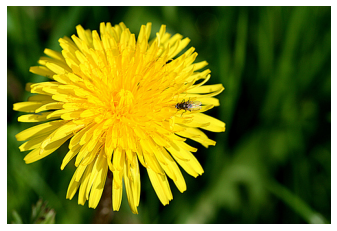

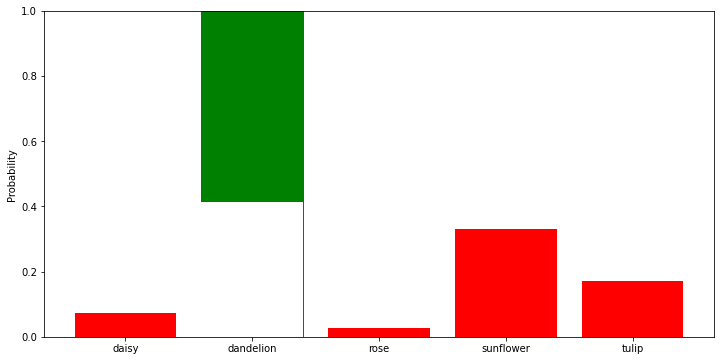

In [36]:
import_and_predict_bayes(image1_dir, label.index('dandelion'))

In [38]:
image2_dir = os.path.join(test_dir+'dandelion/394990940_7af082cf8d_n.jpg')

In [39]:
import_and_predict_bayes(image2_dir, label.index('rose'))

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [41]:
def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread('C:/Users/Mfund/Downloads/flowers/flowers_splitted/val/rose')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 5))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

In [42]:
import_and_predict_bayes(image2_dir, label.index('rose'))

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
